In [1]:
import dataloader
import utilities
import features
import matplotlib.pyplot as plt
import numpy as np


def compute_otsu_criteria(im, th):
    """Otsu's method to compute criteria."""
    # create the thresholded image
    thresholded_im = np.zeros(im.shape)
    thresholded_im[im >= th] = 1

    # compute weights
    nb_pixels = im.size
    nb_pixels1 = np.count_nonzero(thresholded_im)
    weight1 = nb_pixels1 / nb_pixels
    weight0 = 1 - weight1

    # if one of the classes is empty, eg all pixels are below or above the threshold, that threshold will not be considered
    # in the search for the best threshold
    if weight1 == 0 or weight0 == 0:
        return np.inf

    # find all pixels belonging to each class
    val_pixels1 = im[thresholded_im == 1]
    val_pixels0 = im[thresholded_im == 0]

    # compute variance of these classes
    var1 = np.var(val_pixels1) if len(val_pixels1) > 0 else 0
    var0 = np.var(val_pixels0) if len(val_pixels0) > 0 else 0

    return weight0 * var0 + weight1 * var1

def computeRecurrencyPlots(chroma,M,theta):
    N = chroma.shape[1]
    tiny = np.finfo(float).tiny
    S = np.zeros((N-M+1,N-M+1),dtype=float) # self similarity matrix
    for i in range(N-M+1):
        c_1 = chroma[:,i:i+M].flatten() 
        c_1_norm = c_1 / (np.linalg.norm(c_1)+tiny)
        for col_index in range(N-M+1):
            # compute normalized embedded chromavector
            c_2 = chroma[:,col_index:col_index+M].flatten() 
            c_2_norm = c_2 / (np.linalg.norm(c_2)+tiny)
            c_diff = (c_2_norm - c_1_norm)
            S[i,col_index] = np.linalg.norm(c_diff) / 2

    S_1 = np.zeros((N,N),dtype=float) # self similarity matrix
    for i in range(N):
        c_1 = chroma[:,i]
        for col_index in range(N):
            # compute normalized embedded chromavector
            c_2 = chroma[:,col_index]
            c_diff = (c_2- c_1)
            S_1[i,col_index] = np.linalg.norm(c_diff) / 2

    # Adaptive Thresholding
    theta = 10 # nearest neighbours
    threshold = np.zeros((N-M+1,),dtype=float) # treshold for self similarity matrix
    R = np.zeros_like(S)
    for j in range(N-M+1):
        s = S[:,j]
        threshold[j] = np.sort(s)[theta] 

    for i in range(N-M+1):
        for j in range(N-M+1):
            if S[i,j] <= threshold[i] or S[i,j] <= threshold[j]:
                R[i,j] = 1
    W = (1-S) * R
    return S,R,W

def smoothChroma(chroma,W,M):
    chroma_smoothed = np.zeros_like(chroma)
    for n in range(W.shape[0]):
        for m in range(M):
            temp = np.zeros((12,),dtype=float)
            if n - m < 0:  
                continue
            for i in range(W.shape[0]):
                temp += W[i,n - m] * chroma[:,i]
            chroma_smoothed[:,n] += temp / np.sum(W[:,n - m])
    chroma_smoothed[:,W.shape[0]:chroma.shape[1]] = chroma[:,W.shape[0]:chroma.shape[1]]
    chroma_smoothed = chroma_smoothed / np.sum(np.abs(chroma_smoothed)+np.finfo(float).eps,axis=0) # l1 normalization
    return chroma_smoothed

In [36]:

dataset = dataloader.MIRDataset("beatles",basepath="/home/max/ET-TI/Masterarbeit/mirdata/",split_nr=3)
audiopath,gt = dataset["1206"]  # 1206 letitbe, 1208 i've got a feeling,girl  0609, 0304

# 0609 -> Girl: Vocals with guitar, a good example for source separation
t, sig = utilities.loadAudio(audiopath,t_start=150,t_stop=200)
t_chroma, chroma = features.crpChroma(sig,nCRP=33,norm="l2")


In [ ]:

# disregard negative values!
#chroma = np.clip(chroma,0,10)

# compute self similarity matrix
M = 10 # embedding factor 
N = chroma.shape[1]
tiny = np.finfo(float).tiny
S = np.zeros((N-M+1,N-M+1),dtype=float) # self similarity matrix
for i in range(N-M+1):
    c_1 = chroma[:,i:i+M].flatten() 
    c_1_norm = c_1 / (np.linalg.norm(c_1)+tiny)
    for col_index in range(N-M+1):
        # compute normalized embedded chromavector
        c_2 = chroma[:,col_index:col_index+M].flatten() 
        c_2_norm = c_2 / (np.linalg.norm(c_2)+tiny)
        c_diff = (c_2_norm - c_1_norm)
        S[i,col_index] = np.linalg.norm(c_diff) / 2

S_1 = np.zeros((N,N),dtype=float) # self similarity matrix
for i in range(N):
    c_1 = chroma[:,i]
    for col_index in range(N):
        # compute normalized embedded chromavector
        c_2 = chroma[:,col_index]
        c_diff = (c_2- c_1)
        S_1[i,col_index] = np.linalg.norm(c_diff) / 2

# Adaptive Thresholding
theta = 10 # nearest neighbours
threshold = np.zeros((N-M+1,),dtype=float) # treshold for self similarity matrix
R = np.zeros_like(S)
for j in range(N-M+1):
    s = S[:,j]
    threshold[j] = np.sort(s)[theta] 

for i in range(N-M+1):
    for j in range(N-M+1):
        if S[i,j] <= threshold[i] or S[i,j] <= threshold[j]:
            R[i,j] = 1
W = (1-S) * R

# OTSU algorithm
# testing all thresholds from 0 to the maximum of the image
threshold_range = np.arange(0,np.max(S),0.001)
threshold = np.zeros((N-M+1,),dtype=float) 
for i in range(N-M+1):
    criterias = [compute_otsu_criteria(S[:,i], th) for th in threshold_range]
    # best threshold is the one minimizing the Otsu criteria
    best_threshold = threshold_range[np.argmin(criterias)]
    threshold[i] = best_threshold

R_otsu = np.zeros_like(R)
for i in range(N-M+1):
    for j in range(N-M+1):
        if S[i,j] <= threshold[i] or S[i,j] <= threshold[j]:
            R_otsu[i,j] = 1
# R_otsu = S < best_threshold
W_otsu = (1-S)*R_otsu

#W = W_otsu # use OTSU 

chroma_smoothed = np.zeros_like(chroma)
for n in range(N-M+1):
    for m in range(M):
        temp = np.zeros((12,),dtype=float)
        if n - m < 0:  
            continue
        for i in range(N-M+1):
            temp += W[i,n - m] * chroma[:,i]
        chroma_smoothed[:,n] += temp / np.sum(W[:,n - m])
chroma_smoothed[:,N-M+1:N] = chroma[:,N-M+1:N]
            
chroma_smoothed = chroma_smoothed / np.sum(np.abs(chroma_smoothed)+np.finfo(float).eps,axis=0) # l1 normalization




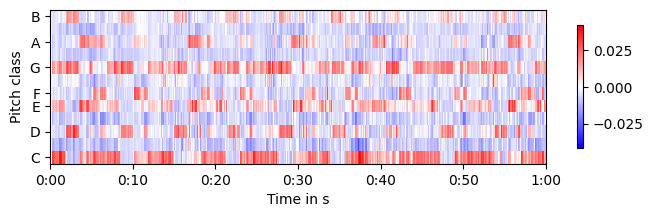

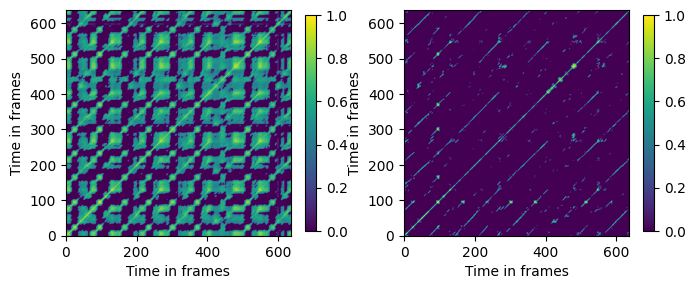

In [312]:
fig,ax = plt.subplots(figsize=(8,2))
img = utilities.plotChromagram(ax,t_chroma,chroma,type="crp")
plt.colorbar(img,ax=ax,shrink=0.8);

fig,ax = plt.subplots(1,2,figsize=(8,4))
img = ax[0].imshow(W_otsu,origin="lower",cmap="binary")

ax[0].set_xlabel("Time in frames")
ax[0].set_ylabel("Time in frames")
plt.colorbar(img,ax=ax[1],shrink=0.7);
img = ax[1].imshow(W,origin="lower",cmap="binary")
ax[1].set_xlabel("Time in frames")
ax[1].set_ylabel("Time in frames")
plt.colorbar(img,ax=ax[0],shrink=0.7);



In [51]:


_,_,W_5 = computeRecurrencyPlots(chroma,5,25)
chroma_5 = smoothChroma(chroma,W_5,5)
_,_,W_25 = computeRecurrencyPlots(chroma,25,25)
chroma_10 = smoothChroma(chroma,W_25,25)


Text(0.9, 0.9, 'M=25\nTheta=50')

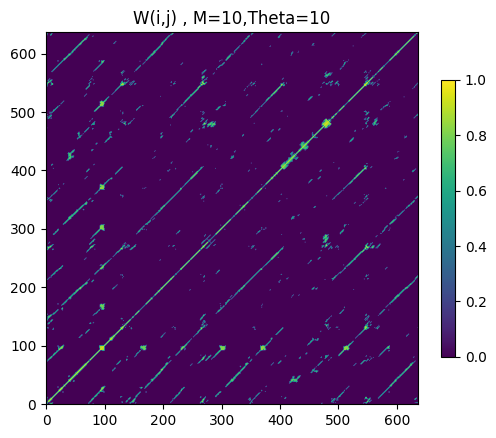

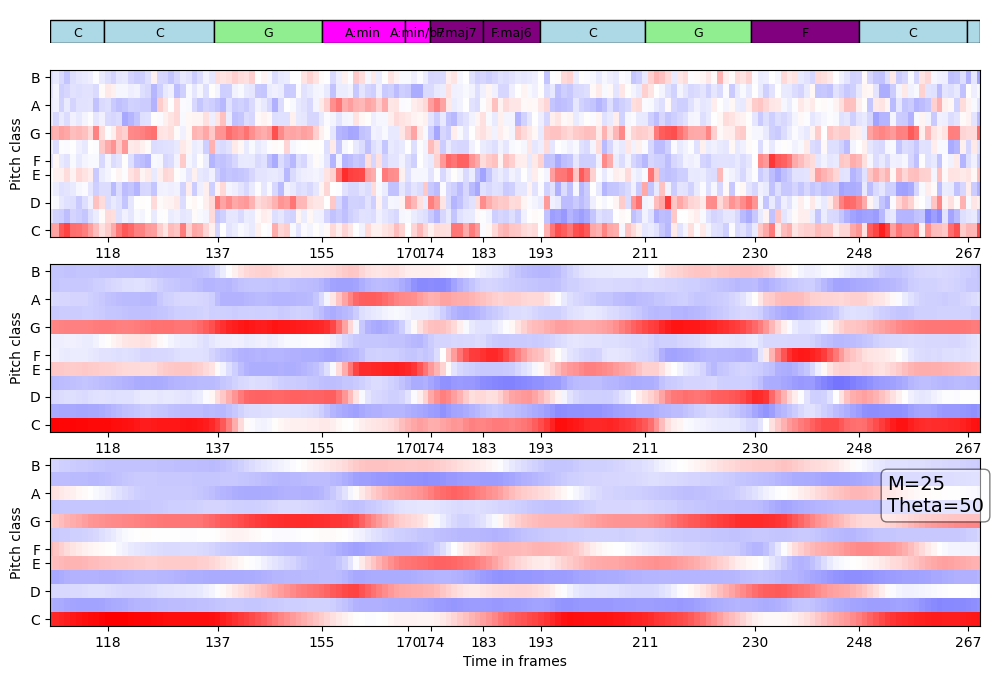

In [50]:

fig,ax = plt.subplots(figsize=(6,6))
img = ax.imshow(W,origin="lower")
ax.set_title(f"W(i,j) , M={M},Theta={theta}")
fig.colorbar(img,ax=ax,shrink=0.6);
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
t_start = 160
t_stop= 175
# compute frame index for chord changes
frames = []
for x in gt[0]:
    if x[1] >= t_start and x[1] <= t_stop:
        frames.append(np.argwhere(t_chroma >= x[1])[0])
x_coords = [x[0] for x in frames]
i0 = np.argwhere(t_chroma >= t_start)[0]
i1 = np.argwhere(t_chroma >= t_stop)[0]
fig,ax = plt.subplots(4,1,height_ratios=(2,10,10,10),figsize=(12,8))
utilities.plotChordAnnotations(ax[0],gt,(t_start,t_stop))
utilities.plotChromagram(ax[1],t_chroma,chroma,type="crp",time=None)
ax[1].set_xticks(x_coords)
ax[1].set_xlim((i0,i1))
utilities.plotChromagram(ax[2],t_chroma,chroma_5,type="crp",time=None)
ax[2].set_xlim((i0,i1))
ax[2].set_xticks(x_coords)
ax[2].text(0.8, 0.9, f"M={5}\nTheta={25}", transform=ax[2].transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
utilities.plotChromagram(ax[3],t_chroma,chroma_10,type="crp",time=None)
ax[3].set_xlim((i0,i1))
ax[3].set_xticks(x_coords)
ax[3].set_xlabel("Time in frames")
ax[3].text(0.8, 0.9, f"M={25}\nTheta={25}", transform=ax[3].transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
